# Sentiment Analysis with BERT

> TL;DR In this tutorial, you'll learn how to fine-tune BERT for sentiment analysis. You'll do the required text preprocessing (special tokens, padding, and attention masks) and build a Sentiment Classifier using the amazing Transformers library by Hugging Face!

- [Read the tutorial](https://www.curiousily.com/posts/sentiment-analysis-with-bert-and-hugging-face-using-pytorch-and-python/)
- [Run the notebook in your browser (Google Colab)](https://colab.research.google.com/drive/1PHv-IRLPCtv7oTcIGbsgZHqrB5LPvB7S)
- [Read the `Getting Things Done with Pytorch` book](https://github.com/curiousily/Getting-Things-Done-with-Pytorch)

You'll learn how to:

- Intuitively understand what BERT is
- Preprocess text data for BERT and build PyTorch Dataset (tokenization, attention masks, and padding)
- Use Transfer Learning to build Sentiment Classifier using the Transformers library by Hugging Face
- Evaluate the model on test data
- Predict sentiment on raw text

Let's get started!

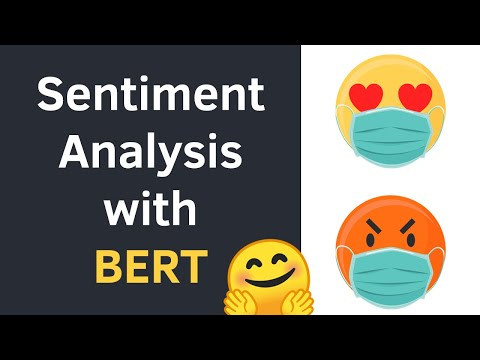

In [ ]:
#@title Watch the video tutorial

from IPython.display import YouTubeVideo
YouTubeVideo('8N-nM3QW7O0', width=720, height=420)

In [1]:
!nvidia-smi

Tue Oct  6 04:09:50 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 455.23.05    Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P8    10W /  70W |      0MiB / 15079MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## What is BERT?

BERT (introduced in [this paper](https://arxiv.org/abs/1810.04805)) stands for Bidirectional Encoder Representations from Transformers. If you don't know what most of that means - you've come to the right place! Let's unpack the main ideas:

- Bidirectional - to understand the text  you're looking you'll have to look back (at the previous words) and forward (at the next words)
- Transformers - The [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper presented the Transformer model. The Transformer reads entire sequences of tokens at once. In a sense, the model is non-directional, while LSTMs read sequentially (left-to-right or right-to-left). The attention mechanism allows for learning contextual relations between words (e.g. `his` in a sentence refers to Jim).
- (Pre-trained) contextualized word embeddings - [The ELMO paper](https://arxiv.org/abs/1802.05365v2) introduced a way to encode words based on their meaning/context. Nails has multiple meanings - fingernails and metal nails.

BERT was trained by masking 15% of the tokens with the goal to guess them. An additional objective was to predict the next sentence. Let's look at examples of these tasks:

### Masked Language Modeling (Masked LM)

The objective of this task is to guess the masked tokens. Let's look at an example, and try to not make it harder than it has to be:

That's `[mask]` she `[mask]` -> That's what she said

### Next Sentence Prediction (NSP)

Given a pair of two sentences, the task is to say whether or not the second follows the first (binary classification). Let's continue with the example:

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Hahaha, nice! [SEP]

*Label* = *IsNext*

*Input* = `[CLS]` That's `[mask]` she `[mask]`. [SEP] Dwight, you ignorant `[mask]`! [SEP]

*Label* = *NotNext*

The training corpus was comprised of two entries: [Toronto Book Corpus](https://arxiv.org/abs/1506.06724) (800M words) and English Wikipedia (2,500M words). While the original Transformer has an encoder (for reading the input) and a decoder (that makes the prediction), BERT uses only the decoder.

BERT is simply a pre-trained stack of Transformer Encoders. How many Encoders? We have two versions - with 12 (BERT base) and 24 (BERT Large).

### Is This Thing Useful in Practice?

The BERT paper was released along with [the source code](https://github.com/google-research/bert) and pre-trained models.

The best part is that you can do Transfer Learning (thanks to the ideas from OpenAI Transformer) with BERT for many NLP tasks - Classification, Question Answering, Entity Recognition, etc. You can train with small amounts of data and achieve great performance!

## Setup

We'll need [the Transformers library](https://huggingface.co/transformers/) by Hugging Face:

In [2]:
!pip install -q -U watermark

In [3]:
!pip install -qq transformers

     |████████████████████████████████| 1.1MB 4.7MB/s 
     |████████████████████████████████| 3.0MB 23.7MB/s 
     |████████████████████████████████| 1.1MB 27.0MB/s 
     |████████████████████████████████| 890kB 57.9MB/s 


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
%reload_ext watermark
%watermark -v -p numpy,pandas,torch,transformers

CPython 3.6.9
IPython 5.5.0

numpy 1.18.5
pandas 1.1.2
torch 1.6.0+cu101
transformers 3.3.1


In [ ]:
#@title Setup & Config
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch

import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

## Data Exploration

We'll load the Google Play app reviews dataset, that we've put together in the previous part:

In [6]:
!gdown --id 1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
!gdown --id 1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv

Downloading...
From: https://drive.google.com/uc?id=1S6qMioqPJjyBLpLVz4gmRTnJHnjitnuV
To: /content/apps.csv
100% 134k/134k [00:00<00:00, 40.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1zdmewp7ayS4js4VtrJEHzAheSW-5NBZv
To: /content/reviews.csv
7.17MB [00:00, 33.4MB/s]


In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"hasanmoni","key":"5fe4d11542815c8b5977365e77970f26"}'}

In [ ]:
!pip install -q kaggle
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json  # set permission

kaggle.json


In [ ]:
#############################################################
# Binary Classification
#############################################################

In [1]:
import numpy as np
import pandas as pd

import os, gc, joblib


from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

import warnings
warnings.filterwarnings("ignore")

### Reading dataset

In [2]:
train = pd.read_csv("/content/drive/My Drive/Colab Notebooks/train.csv")
test = pd.read_csv("/content/drive/My Drive/Colab Notebooks/test.csv")
sample = pd.read_csv("/content/drive/My Drive/Colab Notebooks/sample_submission.csv")

### Adding new column to test data and concating train, test

In [3]:
test["target"] = -1
data = pd.concat([train, test]).reset_index(drop=True)
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,0.0,0.0,0.0,F,N,Red,Trapezoid,Hamster,Russia,Bassoon,de4c57ee2,a64bc7ddf,598080a91,0256c7a4b,02e7c8990,3.0,Contributor,Hot,c,U,Pw,6.0,3.0,0
1,1,1.0,1.0,0.0,F,Y,Red,Star,Axolotl,NaN,Theremin,2bb3c3e5c,3a3a936e8,1dddb8473,52ead350c,f37df64af,3.0,Grandmaster,Warm,e,X,pE,7.0,7.0,0
2,2,0.0,1.0,0.0,F,N,Red,NaN,Hamster,Canada,Bassoon,b574c9841,708248125,5ddc9a726,745b909d1,NaN,3.0,NaN,Freezing,n,P,eN,5.0,9.0,0
3,3,NaN,0.0,0.0,F,N,Red,Circle,Hamster,Finland,Theremin,673bdf1f6,23edb8da3,3a33ef960,bdaa56dd1,f9d456e57,1.0,Novice,Lava Hot,a,C,NaN,3.0,3.0,0
4,4,0.0,NaN,0.0,T,N,Red,Triangle,Hamster,Costa Rica,NaN,777d1ac2c,3a7975e46,bc9cc2a94,NaN,c5361037c,3.0,Grandmaster,Cold,h,C,OZ,5.0,12.0,0


In [11]:
data.tail()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
999995,999995,0.0,0.0,1.0,T,N,Red,Trapezoid,Axolotl,Costa Rica,Theremin,92fb4c0dc,633bdcfd0,3ef3018d3,c1a4acfaf,45a68dd2e,2.0,Expert,Warm,n,R,dp,2.0,12.0,-1
999996,999996,0.0,0.0,0.0,F,N,Red,Polygon,Dog,Russia,Theremin,8bd03e713,7c241cd40,f74f0b894,220190c9e,e48348d66,1.0,Contributor,NaN,n,X,US,1.0,5.0,-1
999997,999997,0.0,0.0,1.0,T,N,Red,Triangle,Hamster,NaN,Theremin,6924d999b,18d43aee8,3afd3697d,cc5495ab3,47021df0d,1.0,Grandmaster,Boiling Hot,m,P,TL,1.0,6.0,-1
999998,999998,0.0,0.0,0.0,F,Y,Red,Circle,Dog,Costa Rica,Theremin,3e0230528,0c073adc7,3600c6e91,32b33a4b4,e4bf32721,3.0,Novice,Lava Hot,h,L,DI,2.0,11.0,-1
999999,999999,0.0,0.0,1.0,F,N,Blue,Circle,Lion,Finland,Bassoon,0568087f1,29b2ef583,69238b544,dda9ca69e,4d921f911,3.0,Contributor,Freezing,c,N,vx,3.0,6.0,-1


In [12]:
data.isna().sum()

id            0
bin_0     29795
bin_1     30041
bin_2     29902
bin_3     29965
bin_4     29998
nom_0     30314
nom_1     30103
nom_2     30214
nom_3     30297
nom_4     30028
nom_5     29690
nom_6     30143
nom_7     30006
nom_8     29711
nom_9     30133
ord_0     30181
ord_1     30208
ord_2     30180
ord_3     29969
ord_4     29863
ord_5     29760
day       29977
month     29972
target        0
dtype: int64

In [13]:
features = [x for x in train.columns if x not in ["id", "target"]]
features

['bin_0',
 'bin_1',
 'bin_2',
 'bin_3',
 'bin_4',
 'nom_0',
 'nom_1',
 'nom_2',
 'nom_3',
 'nom_4',
 'nom_5',
 'nom_6',
 'nom_7',
 'nom_8',
 'nom_9',
 'ord_0',
 'ord_1',
 'ord_2',
 'ord_3',
 'ord_4',
 'ord_5',
 'day',
 'month']

###  Encoding and filling nan data with -1

In [14]:
for feat in features:
    lbl_enc = preprocessing.LabelEncoder()
    data[feat] = lbl_enc.fit_transform(data[feat].fillna("-1").astype(str).values)

In [15]:
data.head()

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,1,1,1,1,1,3,5,4,6,1,1060,1014,88,2,28,3,1,4,3,21,57,6,6,0
1,1,2,2,1,1,2,3,4,1,0,4,211,360,28,70,2113,3,3,6,5,24,151,7,10,0
2,2,1,2,1,1,1,3,0,4,1,1,861,695,91,103,0,3,0,3,14,16,106,5,12,0
3,3,0,1,1,1,1,3,1,4,4,4,478,242,52,171,2168,1,5,5,1,3,0,3,6,0
4,4,1,0,1,2,1,3,6,4,3,0,557,362,183,0,1748,3,3,2,8,3,51,5,4,0


In [16]:
data.isna().sum()

id        0
bin_0     0
bin_1     0
bin_2     0
bin_3     0
bin_4     0
nom_0     0
nom_1     0
nom_2     0
nom_3     0
nom_4     0
nom_5     0
nom_6     0
nom_7     0
nom_8     0
nom_9     0
ord_0     0
ord_1     0
ord_2     0
ord_3     0
ord_4     0
ord_5     0
day       0
month     0
target    0
dtype: int64

### Seperating train and test data

In [18]:
train = data[data.target != -1].reset_index(drop=True)
test = data[data.target == -1].reset_index(drop=True)
train 

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,0,1,1,1,1,1,3,5,4,6,1,1060,1014,88,2,28,3,1,4,3,21,57,6,6,0
1,1,2,2,1,1,2,3,4,1,0,4,211,360,28,70,2113,3,3,6,5,24,151,7,10,0
2,2,1,2,1,1,1,3,0,4,1,1,861,695,91,103,0,3,0,3,14,16,106,5,12,0
3,3,0,1,1,1,1,3,1,4,4,4,478,242,52,171,2168,1,5,5,1,3,0,3,6,0
4,4,1,0,1,2,1,3,6,4,3,0,557,362,183,0,1748,3,3,2,8,3,51,5,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
599995,599995,1,2,1,2,1,3,2,1,5,4,4,1304,165,14,14,3,5,3,1,18,23,5,0,0
599996,599996,2,1,1,2,2,1,2,3,3,2,0,209,128,205,1403,2,5,1,14,14,164,0,6,0
599997,599997,1,1,1,1,2,3,1,1,6,4,958,570,15,179,572,2,1,3,14,8,43,7,8,0
599998,599998,2,2,1,1,2,0,2,1,0,3,348,213,219,53,1712,1,4,6,13,24,19,1,8,0


In [19]:
test

,id,bin_0,bin_1,bin_2,bin_3,bin_4,nom_0,nom_1,nom_2,nom_3,nom_4,nom_5,nom_6,nom_7,nom_8,nom_9,ord_0,ord_1,ord_2,ord_3,ord_4,ord_5,day,month,target
0,600000,1,1,1,1,2,1,2,1,4,3,373,148,141,175,2197,3,5,1,6,21,147,3,12,-1
1,600001,1,1,1,1,2,3,1,5,6,1,485,838,98,5,1108,1,5,2,14,14,0,2,11,-1
2,600002,1,1,1,1,2,1,1,1,6,4,612,677,102,17,813,1,2,6,9,14,13,2,9,-1
3,600003,2,1,1,1,1,3,2,1,3,1,967,1049,190,108,997,1,2,4,13,2,1,1,9,-1
4,600004,1,1,2,1,2,3,1,0,4,4,1157,686,191,31,372,1,1,5,15,10,15,3,6,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399995,999995,1,1,2,2,1,3,5,1,3,4,701,606,58,172,616,2,2,6,14,18,104,2,4,-1
399996,999996,1,1,1,1,1,3,2,3,6,4,668,775,217,30,1987,1,1,0,14,24,80,1,8,-1
399997,999997,1,1,2,2,1,3,6,4,0,4,487,166,53,178,632,1,3,1,13,16,74,1,9,-1
399998,999998,1,1,1,1,2,3,1,3,3,4,291,89,50,45,1988,3,5,5,8,12,12,2,3,-1


In [23]:
train.dtypes

id        int64
bin_0     int64
bin_1     int64
bin_2     int64
bin_3     int64
bin_4     int64
nom_0     int64
nom_1     int64
nom_2     int64
nom_3     int64
nom_4     int64
nom_5     int64
nom_6     int64
nom_7     int64
nom_8     int64
nom_9     int64
ord_0     int64
ord_1     int64
ord_2     int64
ord_3     int64
ord_4     int64
ord_5     int64
day       int64
month     int64
target    int64
dtype: object

In [24]:
test.dtypes

id        int64
bin_0     int64
bin_1     int64
bin_2     int64
bin_3     int64
bin_4     int64
nom_0     int64
nom_1     int64
nom_2     int64
nom_3     int64
nom_4     int64
nom_5     int64
nom_6     int64
nom_7     int64
nom_8     int64
nom_9     int64
ord_0     int64
ord_1     int64
ord_2     int64
ord_3     int64
ord_4     int64
ord_5     int64
day       int64
month     int64
target    int64
dtype: object

In [26]:
# list of array list of every columns
test_data = [test.loc[:, features].values[:, k] for k in range(test.loc[:, features].values.shape[1])]
test_data

[array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 1, 1, 1]),
 array([1, 1, 1, ..., 2, 1, 2]),
 array([1, 1, 1, ..., 2, 1, 1]),
 array([2, 2, 2, ..., 1, 2, 1]),
 array([1, 3, 1, ..., 3, 3, 1]),
 array([2, 1, 1, ..., 6, 1, 1]),
 array([1, 5, 1, ..., 4, 3, 5]),
 array([4, 6, 6, ..., 0, 3, 4]),
 array([3, 1, 4, ..., 4, 4, 1]),
 array([373, 485, 612, ..., 487, 291,  22]),
 array([148, 838, 677, ..., 166,  89, 272]),
 array([141,  98, 102, ...,  53,  50, 101]),
 array([175,   5,  17, ..., 178,  45, 197]),
 array([2197, 1108,  813, ...,  632, 1988,  700]),
 array([3, 1, 1, ..., 1, 3, 3]),
 array([5, 5, 2, ..., 3, 5, 1]),
 array([1, 2, 6, ..., 1, 5, 3]),
 array([ 6, 14,  9, ..., 13,  8,  3]),
 array([21, 14, 14, ..., 16, 12, 14]),
 array([147,   0,  13, ...,  74,  12, 178]),
 array([3, 2, 2, ..., 1, 2, 3]),
 array([12, 11,  9, ...,  9,  3,  9])]

In [21]:
len(test_data[0])

400000

In [27]:
oof_preds = np.zeros((len(train)))
test_preds = np.zeros((len(test)))

In [33]:
def create_model(data, catcols):    
    inputs = []
    outputs = []
    
    for c in catcols:
        num_unique_values = int(data[c].nunique())
        embed_dim = int(min(np.ceil((num_unique_values)/2), 50))
        inp = layers.Input(shape=(1,))
        out = layers.Embedding(num_unique_values + 1, embed_dim, name=c)(inp)
        out = layers.SpatialDropout1D(0.3)(out)
        out = layers.Reshape(target_shape=(embed_dim, ))(out)
        inputs.append(inp)
        outputs.append(out)
    
    x = layers.Concatenate()(outputs)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(300, activation="relu")(x)
    x = layers.Dropout(0.3)(x)
    x = layers.BatchNormalization()(x)
    
    y = layers.Dense(2, activation="softmax")(x)

    model = Model(inputs=inputs, outputs=y)
    return model

In [34]:
def auc(y_true, y_pred):
    def fallback_auc(y_true, y_pred):
        try:
            return metrics.roc_auc_score(y_true, y_pred)
        except:
            return 0.5
    return tf.py_function(fallback_auc, (y_true, y_pred), tf.double)

In [ ]:
skf = StratifiedKFold(n_splits=50)

for train_index, test_index in skf.split(train, train.target.values):
    X_train, X_test = train.iloc[train_index, :], train.iloc[test_index, :]
    
    X_train = X_train.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    y_train, y_test = X_train.target.values, X_test.target.values
    
    model = create_model(data, features)
    
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[auc])
    
    X_train = [X_train.loc[:, features].values[:, k] for k in range(X_train.loc[:, features].values.shape[1])]
    X_test = [X_test.loc[:, features].values[:, k] for k in range(X_test.loc[:, features].values.shape[1])]
    
    es = callbacks.EarlyStopping(monitor='val_auc', min_delta=0.001, patience=5,
                                 verbose=1, mode='max', baseline=None, restore_best_weights=True)

    rlr = callbacks.ReduceLROnPlateau(monitor='val_auc', factor=0.5,
                                      patience=3, min_lr=1e-6, mode='max', verbose=1)
    
    model.fit(X_train,
              utils.to_categorical(y_train),
              validation_data=(X_test, utils.to_categorical(y_test)),
              verbose=1,
              batch_size=1024,
              callbacks=[es, rlr],
              epochs=100
             )
    
    valid_fold_preds = model.predict(X_test)[:, 1]
    test_fold_preds = model.predict(test_data)[:, 1]
    oof_preds[test_index] = valid_fold_preds.ravel()
    test_preds += test_fold_preds.ravel()
    print(metrics.roc_auc_score(y_test, valid_fold_preds))
    K.clear_session()

Epoch 1/100
575/575 [==============================] - 10s 18ms/step - loss: 0.4689 - auc: 0.7011 - val_loss: 0.4086 - val_auc: 0.7768
Epoch 2/100
575/575 [==============================] - 10s 18ms/step - loss: 0.4085 - auc: 0.7701 - val_loss: 0.4002 - val_auc: 0.7803
Epoch 3/100
575/575 [==============================] - 10s 18ms/step - loss: 0.4030 - auc: 0.7786 - val_loss: 0.3997 - val_auc: 0.7818
Epoch 4/100
575/575 [==============================] - 10s 17ms/step - loss: 0.4006 - auc: 0.7823 - val_loss: 0.4005 - val_auc: 0.7822
Epoch 5/100
575/575 [==============================] - 10s 17ms/step - loss: 0.3987 - auc: 0.7854 - val_loss: 0.4006 - val_auc: 0.7813
Epoch 6/100
575/575 [==============================] - 10s 18ms/step - loss: 0.3962 - auc: 0.7886 - val_loss: 0.4025 - val_auc: 0.7812
Epoch 7/100
574/575 [============================>.] - ETA: 0s - loss: 0.3935 - auc: 0.7928
Epoch 00007: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
575/575 [=========

In [ ]:
print("Overall AUC={}".format(metrics.roc_auc_score(train.target.values, oof_preds)))

In [ ]:
test_preds /= 50
test_ids = test.id.values
print("Saving submission file")
submission = pd.DataFrame.from_dict({
    'id': test_ids,
    'target': test_preds
})
submission.to_csv("submission.csv", index=False)